V1
* Matern 5/2
* 1 candidate per iteration

In [1]:
import os
os.chdir(os.getcwd() + '/../')
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.double
SMOKE_TEST = os.environ.get("SMOKE_TEST")

In [2]:
from botorch.test_functions import Hartmann, Ackley

NOISE_SE = 0.25
train_yvar = torch.tensor(NOISE_SE**2, device=device, dtype=dtype)

neg_hartmann6 = Hartmann(noise_std=NOISE_SE, negate=True)

def modified_hartmann6(X: torch.Tensor)->torch.Tensor:
    '''
    Hartmann 6 function with x extremum shifted to [0]*6
    '''
    x_shift = torch.tensor([[0.20169, 0.150011, 0.476874, 0.275332, 0.311652, 0.6573]]).to(X)
    return neg_hartmann6(X+x_shift)

def modified_ackley(X: torch.Tensor)->torch.Tensor:
    neg_ackley = Ackley(dim=6, noise_std=NOISE_SE, negate=True)
    return neg_ackley(X*4-2)

In [3]:
from botorch.acquisition.objective import MCAcquisitionObjective, IdentityMCObjective
from scripts.utils import *

TARGET_BOUNDS_1 = [3, 3.33]
BOUNDS_1 = [0, 4]

TARGET_BOUNDS_2 = [-1, 0.0]
BOUNDS_2 = [-12, 0.5]


class CustomObjectiveSmooth(MCAcquisitionObjective):
    
    def objective_1(self, samples):
        return smooth_objective(samples[..., 0], lower=TARGET_BOUNDS_1[0], upper=TARGET_BOUNDS_1[1], steepness=100)
    def objective_2(self, samples):
        return smooth_objective(samples[..., 1], lower=TARGET_BOUNDS_2[0], upper=TARGET_BOUNDS_2[1], steepness=100)
    def forward(self, samples, X=None):
        obj_1 = self.objective_1(samples)
        obj_2 = self.objective_2(samples)
        obj = (obj_1 + obj_2)/2
        return obj
    
    
class CustomObjectiveSharp(MCAcquisitionObjective):
    
    def objective_1(self, samples):
        return sharp_objective(samples[..., 0], TARGET_BOUNDS_1, BOUNDS_1)
    def objective_2(self, samples):
        return sharp_objective(samples[..., 1], TARGET_BOUNDS_2, BOUNDS_2)
    def forward(self, samples, X=None):
        obj_1 = self.objective_1(samples)
        obj_2 = self.objective_2(samples)
        obj = (obj_1 + obj_2)/2
        return obj
    
class CustomObjectiveHybrid(MCAcquisitionObjective):
    
    def objective_1(self, samples):
        return hybrid_objective(samples[..., 0], lower=TARGET_BOUNDS_1[0], upper=TARGET_BOUNDS_1[1], steepness=0.5)
    def objective_2(self, samples):
        return hybrid_objective(samples[..., 1], lower=TARGET_BOUNDS_2[0], upper=TARGET_BOUNDS_2[1], steepness=0.5)
    def forward(self, samples, X=None):
        obj_1 = self.objective_1(samples)
        obj_2 = self.objective_2(samples)
        obj = (obj_1 + obj_2)/2
        return obj
    
class CustomObjectiveMean(MCAcquisitionObjective):
    
    def objective_1(self, samples):
        return samples[..., 0]
    def objective_2(self, samples):
        return samples[..., 1]
    def  forward(self, samples, X=None):
        return (self.objective_1(samples) + self.objective_2(samples))/2
    

co_smooth = CustomObjectiveSmooth()
co_sharp = CustomObjectiveSharp()
co_hybrid = CustomObjectiveHybrid()

In [4]:
from botorch.models import FixedNoiseGP, ModelListGP
from botorch.models.gp_regression import SingleTaskGP
from botorch.models.transforms.outcome import Standardize
from gpytorch.mlls.sum_marginal_log_likelihood import SumMarginalLogLikelihood
from botorch.utils.sampling import draw_sobol_samples
from gpytorch.kernels import MaternKernel, ScaleKernel

CENTER_1 = (TARGET_BOUNDS_1[0] + TARGET_BOUNDS_1[1])/2
CENTER_2 = (TARGET_BOUNDS_2[0] + TARGET_BOUNDS_2[1])/2
X_BOUNDS = torch.tensor([[0.0] * 6, [1.0] * 6], device=device, dtype=dtype)
KERNEL = ScaleKernel(MaternKernel(nu=2.5, ard_num_dims=6))


def generate_initial_data(n, objective):
    # generate training data
    train_x = draw_sobol_samples(X_BOUNDS, 1, q=n).squeeze(0).to(device=device, dtype=dtype)
    train_y_1 = modified_hartmann6(train_x).unsqueeze(-1)
    train_y_2 = modified_ackley(train_x).unsqueeze(-1)
    train_y = torch.cat([train_y_1, train_y_2], dim=-1)
    best_observed_values = objective.forward(train_y).max().item()
    return train_x, train_y, best_observed_values
    
    
def initialize_model(train_x, train_y, state_dict=None):
    # define models for objective and constraint
    model_obj_1 = SingleTaskGP(train_x, 
                               train_y[:, 0:1],
                               covar_module=KERNEL,
                               outcome_transform=Standardize(m=1)).to(train_x)
    model_obj_2 = SingleTaskGP(train_x, 
                               train_y[:, 1:2],
                               covar_module=KERNEL,
                               outcome_transform=Standardize(m=1)).to(train_x)
    # combine into a multi-output GP model
    model = ModelListGP(model_obj_1, model_obj_2)
    mll = SumMarginalLogLikelihood(model.likelihood, model)
    # load state dict if it is passed
    if state_dict is not None:
        model.load_state_dict(state_dict)
    return mll, model

In [5]:
from botorch.optim import optimize_acqf


BATCH_SIZE = 1
NUM_RESTARTS = 20
RAW_SAMPLES = 512


def optimize_acqf_and_get_observation(model, train_x, objective):
    """Optimizes the acquisition function, and returns a new candidate and a noisy observation."""
    # acqf
    qNEI = qNoisyExpectedImprovement(
            model=model, 
            X_baseline=train_x,
            sampler=qmc_sampler, 
            objective=objective,
        )
    
    # optimize
    candidates, _ = optimize_acqf(
        acq_function=qNEI,
        bounds=X_BOUNDS,
        q=BATCH_SIZE,
        num_restarts=NUM_RESTARTS,
        raw_samples=RAW_SAMPLES,  # used for intialization heuristic
        options={"batch_limit": 5, "maxiter": 200},
    )
    # observe new values 
    new_x = candidates.detach()
    new_y_1 = neg_hartmann6(new_x).unsqueeze(-1)  # add output dimension
    new_y_2 = modified_ackley(new_x).unsqueeze(-1)  # add output dimension
    new_y = torch.cat([new_y_1, new_y_2], dim=-1)
    return new_x, new_y


def update_random_observations(best_random, objective):
    """Simulates a random policy by taking a the current list of best values observed randomly,
    drawing a new random point, observing its value, and updating the list.
    """
    rand_x = torch.rand(BATCH_SIZE, 6)
    rand_y_1 = modified_hartmann6(rand_x).unsqueeze(-1)  # add output dimension
    rand_y_2 = modified_ackley(rand_x).unsqueeze(-1)  # add output dimension
    rand_y = torch.cat([rand_y_1, rand_y_2], dim=-1)
    next_random_best = objective.forward(rand_y).max().item()
    best_random.append(max(best_random[-1], next_random_best))
    return best_random

### BO Loop

In [6]:
from botorch import fit_gpytorch_model
from botorch.acquisition.monte_carlo import qExpectedImprovement, qNoisyExpectedImprovement
from botorch.sampling.samplers import SobolQMCNormalSampler
from botorch.exceptions import BadInitialCandidatesWarning

import time
import warnings


warnings.filterwarnings('ignore', category=BadInitialCandidatesWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)


N_TRIALS = 20
N_BATCH = 150
MC_SAMPLES = 512

verbose = False

best_observed_all_smooth, best_observed_all_sharp, best_observed_all_hybrid = [], [], []


# average over multiple trials
for trial in range(1, N_TRIALS + 1):
    
    print(f"\nTrial {trial:>2} of {N_TRIALS} ", end="")
    best_observed_smooth, best_observed_sharp, best_observed_hybrid = [], [], []
    
    # call helper functions to generate initial training data and initialize model
    train_x_smooth, train_y_smooth, best_observed_value_smooth = generate_initial_data(10, co_smooth)
    mll_smooth, model_smooth = initialize_model(train_x_smooth, train_y_smooth)
    
    train_x_sharp, train_y_sharp = train_x_smooth, train_y_smooth
    best_observed_value_sharp = best_observed_value_smooth
    mll_sharp, model_sharp = initialize_model(train_x_sharp, train_y_sharp)
    
    train_x_hybrid, train_y_hybrid = train_x_smooth, train_y_smooth
    best_observed_value_hybrid = best_observed_value_smooth
    mll_hybrid, model_hybrid = initialize_model(train_x_sharp, train_y_sharp)
    
    best_observed_smooth.append(best_observed_value_smooth)
    best_observed_sharp.append(best_observed_value_sharp)
    best_observed_hybrid.append(best_observed_value_hybrid)
    
    # run N_BATCH rounds of BayesOpt after the initial random batch
    for iteration in range(1, N_BATCH + 1):    
        
        t0 = time.time()
        
        # fit the models
        fit_gpytorch_model(mll_smooth)
        fit_gpytorch_model(mll_sharp)
        fit_gpytorch_model(mll_hybrid)
        
        # define the qEI and qNEI acquisition modules using a QMC sampler
        qmc_sampler = SobolQMCNormalSampler(num_samples=MC_SAMPLES)
        
        # optimize and get new observation
        new_x_smooth, new_y_smooth = optimize_acqf_and_get_observation(model_smooth, train_x_smooth, co_smooth)
        new_x_sharp, new_y_sharp = optimize_acqf_and_get_observation(model_sharp, train_x_sharp, co_sharp)
        new_x_hybrid, new_y_hybrid = optimize_acqf_and_get_observation(model_hybrid, train_x_hybrid, co_hybrid)
                
        # update training points
        train_x_smooth = torch.cat([train_x_smooth, new_x_smooth])
        train_y_smooth = torch.cat([train_y_smooth, new_y_smooth])

        train_x_sharp = torch.cat([train_x_sharp, new_x_sharp])
        train_y_sharp = torch.cat([train_y_sharp, new_y_sharp])
        
        train_x_hybrid = torch.cat([train_x_hybrid, new_x_hybrid])
        train_y_hybrid = torch.cat([train_y_hybrid, new_y_hybrid])

        # update progress
        best_value_smooth = co_sharp.forward(train_y_smooth).max().item()   # both use sharp to compute best values
        best_value_sharp = co_sharp.forward(train_y_sharp).max().item()    # both use sharp to compute best values
        best_value_hybrid = co_sharp.forward(train_y_hybrid).max().item()    # both use sharp to compute best values
        
        best_observed_smooth.append(best_value_smooth)
        best_observed_sharp.append(best_value_sharp)
        best_observed_hybrid.append(best_value_hybrid)

        # reinitialize the models so they are ready for fitting on next iteration
        # use the current state dict to speed up fitting
        mll_smooth, model_smooth = initialize_model(
            train_x_smooth, 
            train_y_smooth, 
            model_smooth.state_dict(),
        )
        mll_sharp, model_sharp = initialize_model(
            train_x_sharp, 
            train_y_sharp, 
            model_sharp.state_dict(),
        )
        mll_hybrid, model_hybrid = initialize_model(
            train_x_hybrid, 
            train_y_hybrid, 
            model_hybrid.state_dict(),
        )
        
        t1 = time.time()
        
        if verbose:
            print(
                f"\nBatch {iteration:>2}: best_value (qNEI_smooth, qNEI_sharp, qNEI_hybrid) = "
                f"( {best_value_smooth:>4.2f}, {best_value_sharp:>4.2f}, {best_value_hybrid:>4.2f}), "
                f"time = {t1-t0:>4.2f}.", end=""
            )
        else:
            print(".", end="")
   
    best_observed_all_smooth.append(best_observed_smooth)
    best_observed_all_sharp.append(best_observed_sharp)
    best_observed_all_hybrid.append(best_observed_hybrid)


Trial  1 of 20 ......................................................................................................................................................
Trial  2 of 20 ......................................................................................................................................................
Trial  3 of 20 ......................................................................................................................................................
Trial  4 of 20 ......................................................................................................................................................
Trial  5 of 20 ......................................................................................................................................................
Trial  6 of 20 ......................................................................................................................................................
Tri

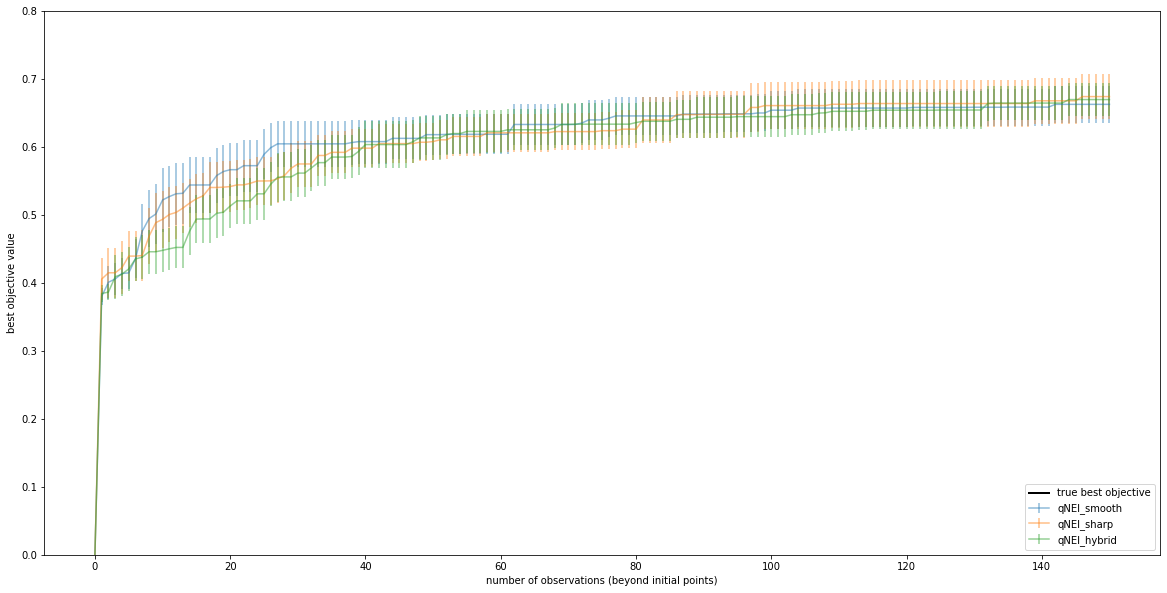

In [10]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline


def ci(y):
    return 1.96 * y.std(axis=0) / np.sqrt(N_TRIALS)


GLOBAL_MAXIMUM = 1.0


iters = np.arange(N_BATCH + 1) * BATCH_SIZE
y_smooth = np.asarray(best_observed_all_smooth)
y_sharp = np.asarray(best_observed_all_sharp)
y_hybrid = np.asarray(best_observed_all_hybrid)

fig, ax = plt.subplots(1, 1, figsize=(20, 10))
# ax.errorbar(iters, y_rnd_smooth.mean(axis=0), yerr=ci(y_rnd_smooth), label="random_smooth", linewidth=1.5, alpha=0.5)
ax.errorbar(iters, y_smooth.mean(axis=0), yerr=ci(y_smooth), label="qNEI_smooth", linewidth=1.5, alpha=0.5)
ax.errorbar(iters, y_sharp.mean(axis=0), yerr=ci(y_sharp), label="qNEI_sharp", linewidth=1.5, alpha=0.5)
ax.errorbar(iters, y_hybrid.mean(axis=0), yerr=ci(y_hybrid), label="qNEI_hybrid", linewidth=1.5, alpha=0.5)
plt.plot([0, N_BATCH * BATCH_SIZE], [GLOBAL_MAXIMUM] * 2, 'k', label="true best objective", linewidth=2)
ax.set_ylim(bottom=0.0, top=0.8)
ax.set(xlabel='number of observations (beyond initial points)', ylabel='best objective value')
ax.legend(loc="lower right")